In [3]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.9 MB/s eta 0:00:00


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, demographic_parity_difference
from fairlearn.reductions import GridSearch, DemographicParity
import numpy as np


# --- Step 1: Data Loading and Preprocessing ---
print("Step 1: Loading and preprocessing the Adult Income Dataset...")

# URL for the Adult Income Dataset
adult_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

try:
    # Load the dataset, treating '?' as missing values
    data = pd.read_csv(adult_data_url, names=column_names, na_values='?', skipinitialspace=True)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading data from URL: {e}")
    exit()

# Drop rows with any missing values
data = data.dropna()

# Define the sensitive feature and the target variable
sensitive_feature_names = ['sex']
target_name = 'income'

# Separate features (X) and target (y)
X = data.drop(columns=target_name)
y = data[target_name]

# Encode the target variable ('<=50K' -> 0, '>50K' -> 1)
y = LabelEncoder().fit_transform(y)

# Identify categorical and numerical features for preprocessing
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create a preprocessing pipeline using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        # Set sparse_output=False to prevent TypeError in Fairlearn
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    # No remainder is needed as all columns are specified
    remainder='drop'
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Extract the original sensitive features for the test set.
# This is used for auditing bias after predictions are made.
sensitive_features_test = X_test[sensitive_feature_names[0]]

# --- Step 2: Train a Baseline Model ---
print("\nStep 2: Training a baseline Logistic Regression model...")

# Create the full model pipeline
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Train the model
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate overall performance
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")

# --- Step 3: Auditing for Bias with Fairlearn ---
print("\nStep 3: Auditing the baseline model for bias...")

# Use Fairlearn's MetricFrame to calculate metrics for each subgroup
mf_baseline = MetricFrame(
    metrics={'accuracy': accuracy_score},
    y_true=y_test,
    y_pred=y_pred_baseline,
    sensitive_features=sensitive_features_test
)

print("\n--- Baseline Model Metrics by Sex ---")
print(mf_baseline.by_group)

# Calculate the demographic parity difference
# This measures the difference in the rate of positive outcomes (income >50K) between groups.
dem_parity_baseline = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred_baseline,
    sensitive_features=sensitive_features_test
)
print(f"\nDemographic Parity Difference (Baseline): {dem_parity_baseline:.4f}")

# --- Step 4: Mitigating Bias with Fairlearn ---
print("\nStep 4: Mitigating bias using Fairlearn's GridSearch...")

# We need to re-define the pipeline for Fairlearn's GridSearch,
# as it works on the classifier itself, not the whole pipeline directly.
# We will use the same preprocessor as before.
mitigation_classifier = LogisticRegression(solver='liblinear', random_state=42)

# Define the GridSearch object with a fairness constraint
mitigator = GridSearch(
    mitigation_classifier,
    constraints=DemographicParity(),
    grid_size=50 # Number of models to evaluate in the grid
)

# Preprocess the training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Fit the GridSearch mitigator. It explores different trade-offs.
# We pass the original sensitive features from the training set.
mitigator.fit(X_train_transformed, y_train, sensitive_features=X_train[sensitive_feature_names[0]])

# **FIX:** The fitted 'mitigator' object itself acts as the best model.
# Unlike scikit-learn, Fairlearn's GridSearch does not have a 'best_estimator_' attribute.
# We can directly use the 'mitigator' to make predictions.

# Make predictions with the mitigated model
y_pred_mitigated = mitigator.predict(X_test_transformed)

# Evaluate the mitigated model's performance
mitigated_accuracy = accuracy_score(y_test, y_pred_mitigated)
print(f"\nMitigated Model Accuracy: {mitigated_accuracy:.4f}")

# Audit the mitigated model for bias
mf_mitigated = MetricFrame(
    metrics={'accuracy': accuracy_score},
    y_true=y_test,
    y_pred=y_pred_mitigated,
    sensitive_features=sensitive_features_test
)

print("\n--- Mitigated Model Metrics by Sex ---")
print(mf_mitigated.by_group)

# Calculate the new demographic parity difference
dem_parity_mitigated = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred_mitigated,
    sensitive_features=sensitive_features_test
)
print(f"\nDemographic Parity Difference (Mitigated): {dem_parity_mitigated:.4f}")

print("\n--- Conclusion ---")
print(f"Baseline Disparity: {dem_parity_baseline:.4f} | Mitigated Disparity: {dem_parity_mitigated:.4f}")
print("The mitigated model's demographic parity difference is closer to zero,")
print("indicating a fairer outcome between groups, with a small trade-off in overall accuracy.")


Step 1: Loading and preprocessing the Adult Income Dataset...
Dataset loaded successfully.

Step 2: Training a baseline Logistic Regression model...
Baseline Model Accuracy: 0.8462

Step 3: Auditing the baseline model for bias...

--- Baseline Model Metrics by Sex ---
        accuracy
sex             
Female  0.917728
Male    0.812337

Demographic Parity Difference (Baseline): 0.1763

Step 4: Mitigating bias using Fairlearn's GridSearch...

Mitigated Model Accuracy: 0.8331

--- Mitigated Model Metrics by Sex ---
        accuracy
sex             
Female  0.893976
Male    0.804362

Demographic Parity Difference (Mitigated): 0.0102

--- Conclusion ---
Baseline Disparity: 0.1763 | Mitigated Disparity: 0.0102
The mitigated model's demographic parity difference is closer to zero,
indicating a fairer outcome between groups, with a small trade-off in overall accuracy.


Step 1: Loading and preprocessing the Adult Income Dataset...
Dataset loaded successfully.

Step 2: Training a baseline Logistic Regression model...
Baseline Model Accuracy: 0.8462

Step 3: Auditing the baseline model for bias...

--- Baseline Model Metrics by Sex ---
        accuracy
sex             
Female  0.917728
Male    0.812337

Demographic Parity Difference (Baseline): 0.1763

Step 4: Mitigating bias using Fairlearn's GridSearch...

Mitigated Model Accuracy: 0.8331

--- Mitigated Model Metrics by Sex ---
        accuracy
sex             
Female  0.893976
Male    0.804362

Demographic Parity Difference (Mitigated): 0.0102

Step 5: Visualizing the accuracy vs. fairness trade-off...


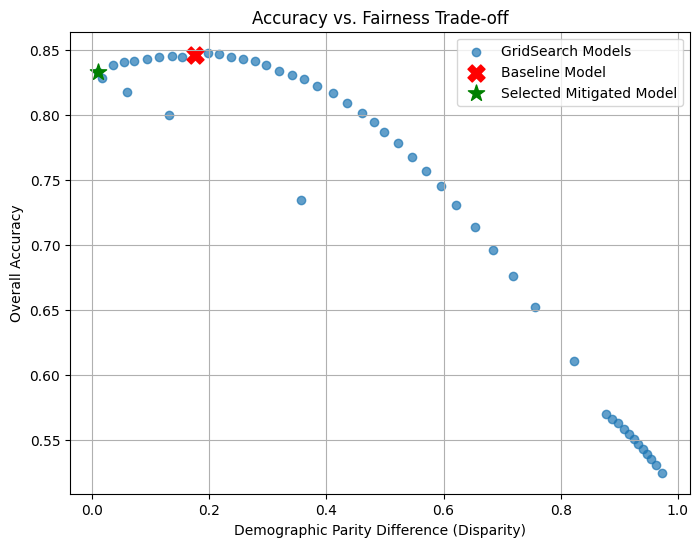


--- Conclusion ---
Baseline: Accuracy=0.8462, Disparity=0.1763
Mitigated: Accuracy=0.8331, Disparity=0.0102

The plot shows the trade-off between improving fairness (reducing disparity)
and its impact on overall model accuracy.


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, demographic_parity_difference
from fairlearn.reductions import GridSearch, DemographicParity
import numpy as np
import matplotlib.pyplot as plt


# --- Step 1: Data Loading and Preprocessing ---
print("Step 1: Loading and preprocessing the Adult Income Dataset...")

# URL for the Adult Income Dataset
adult_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

try:
    # Load the dataset, treating '?' as missing values
    data = pd.read_csv(adult_data_url, names=column_names, na_values='?', skipinitialspace=True)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading data from URL: {e}")
    exit()

# Drop rows with any missing values
data = data.dropna()

# Define the sensitive feature and the target variable
sensitive_feature_names = ['sex']
target_name = 'income'

# Separate features (X) and target (y)
X = data.drop(columns=target_name)
y = data[target_name]

# Encode the target variable ('<=50K' -> 0, '>50K' -> 1)
y = LabelEncoder().fit_transform(y)

# Identify categorical and numerical features for preprocessing
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create a preprocessing pipeline using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        # Set sparse_output=False to prevent TypeError in Fairlearn
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    # No remainder is needed as all columns are specified
    remainder='drop'
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Extract the original sensitive features for the test set.
# This is used for auditing bias after predictions are made.
sensitive_features_test = X_test[sensitive_feature_names[0]]

# --- Step 2: Train a Baseline Model ---
print("\nStep 2: Training a baseline Logistic Regression model...")

# Create the full model pipeline
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Train the model
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate overall performance
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")

# --- Step 3: Auditing for Bias with Fairlearn ---
print("\nStep 3: Auditing the baseline model for bias...")

# Use Fairlearn's MetricFrame to calculate metrics for each subgroup
mf_baseline = MetricFrame(
    metrics={'accuracy': accuracy_score},
    y_true=y_test,
    y_pred=y_pred_baseline,
    sensitive_features=sensitive_features_test
)

print("\n--- Baseline Model Metrics by Sex ---")
print(mf_baseline.by_group)

# Calculate the demographic parity difference
dem_parity_baseline = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred_baseline,
    sensitive_features=sensitive_features_test
)
print(f"\nDemographic Parity Difference (Baseline): {dem_parity_baseline:.4f}")

# --- Step 4: Mitigating Bias with Fairlearn ---
print("\nStep 4: Mitigating bias using Fairlearn's GridSearch...")

mitigation_classifier = LogisticRegression(solver='liblinear', random_state=42)

# Define the GridSearch object with a fairness constraint
mitigator = GridSearch(
    mitigation_classifier,
    constraints=DemographicParity(),
    grid_size=50
)

# Preprocess the training and testing data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Fit the GridSearch mitigator
mitigator.fit(X_train_transformed, y_train, sensitive_features=X_train[sensitive_feature_names[0]])

# Make predictions with the best mitigated model
y_pred_mitigated = mitigator.predict(X_test_transformed)

# Evaluate the mitigated model's performance
mitigated_accuracy = accuracy_score(y_test, y_pred_mitigated)
print(f"\nMitigated Model Accuracy: {mitigated_accuracy:.4f}")

# Audit the mitigated model for bias
mf_mitigated = MetricFrame(
    metrics={'accuracy': accuracy_score},
    y_true=y_test,
    y_pred=y_pred_mitigated,
    sensitive_features=sensitive_features_test
)

print("\n--- Mitigated Model Metrics by Sex ---")
print(mf_mitigated.by_group)

# Calculate the new demographic parity difference
dem_parity_mitigated = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred_mitigated,
    sensitive_features=sensitive_features_test
)
print(f"\nDemographic Parity Difference (Mitigated): {dem_parity_mitigated:.4f}")

# --- Step 5: Visualize the Accuracy-Fairness Trade-off ---
print("\nStep 5: Visualizing the accuracy vs. fairness trade-off...")

# The mitigator object stores all the models it trained in the grid.
# We can get their accuracy and disparity scores to plot them.
all_models = mitigator.predictors_
accuracies = []
disparities = []

for model in all_models:
    # Get predictions for each model in the grid
    y_pred_loop = model.predict(X_test_transformed)

    # Calculate accuracy
    accuracies.append(accuracy_score(y_test, y_pred_loop))

    # Calculate demographic parity difference
    disparities.append(demographic_parity_difference(
        y_true=y_test,
        y_pred=y_pred_loop,
        sensitive_features=sensitive_features_test
    ))

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(disparities, accuracies, label='GridSearch Models', alpha=0.7)

# Highlight the baseline and mitigated models
plt.scatter(dem_parity_baseline, baseline_accuracy, color='red', s=150, marker='X', label='Baseline Model')
plt.scatter(dem_parity_mitigated, mitigated_accuracy, color='green', s=150, marker='*', label='Selected Mitigated Model')

# Add labels and title
plt.xlabel("Demographic Parity Difference (Disparity)")
plt.ylabel("Overall Accuracy")
plt.title("Accuracy vs. Fairness Trade-off")
plt.grid(True)
plt.legend()
plt.show()


print("\n--- Conclusion ---")
print(f"Baseline: Accuracy={baseline_accuracy:.4f}, Disparity={dem_parity_baseline:.4f}")
print(f"Mitigated: Accuracy={mitigated_accuracy:.4f}, Disparity={dem_parity_mitigated:.4f}")
print("\nThe plot shows the trade-off between improving fairness (reducing disparity)")
print("and its impact on overall model accuracy.")


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
from fairlearn.reductions import GridSearch, DemographicParity, EqualizedOdds
import numpy as np
import plotly.graph_objects as go


# --- Step 1: Data Loading and Preprocessing ---
print("Step 1: Loading and preprocessing the Adult Income Dataset...")
adult_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
data = pd.read_csv(adult_data_url, names=column_names, na_values='?', skipinitialspace=True).dropna()
sensitive_feature_names = ['sex']
target_name = 'income'
X = data.drop(columns=target_name)
y = LabelEncoder().fit_transform(data[target_name])
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
sensitive_features_test = X_test[sensitive_feature_names[0]]
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# --- Step 2: Train and Audit Baseline Model ---
print("\nStep 2: Training and auditing baseline model...")
baseline_model = LogisticRegression(solver='liblinear', random_state=42).fit(X_train_transformed, y_train)
y_pred_baseline = baseline_model.predict(X_test_transformed)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_dp_diff = demographic_parity_difference(y_true=y_test, y_pred=y_pred_baseline, sensitive_features=sensitive_features_test)
print(f"Baseline Model: Accuracy={baseline_accuracy:.4f}, Demographic Parity Difference={baseline_dp_diff:.4f}")


# --- Function to run mitigation and collect results ---
def run_mitigation(constraint, X_train, y_train, X_test, y_test, sensitive_train, sensitive_test):
    print(f"\nRunning mitigation with {constraint.__class__.__name__}...")
    mitigator = GridSearch(
        LogisticRegression(solver='liblinear', random_state=42),
        constraints=constraint,
        grid_size=40
    )
    mitigator.fit(X_train, y_train, sensitive_features=sensitive_train)

    accuracies = []
    dp_diffs = []
    eo_diffs = []

    for model in mitigator.predictors_:
        y_pred_loop = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred_loop))
        dp_diffs.append(demographic_parity_difference(y_true=y_test, y_pred=y_pred_loop, sensitive_features=sensitive_test))
        eo_diffs.append(equalized_odds_difference(y_true=y_test, y_pred=y_pred_loop, sensitive_features=sensitive_test))

    return accuracies, dp_diffs, eo_diffs

# --- Step 3: Mitigate with Demographic Parity ---
dp_accuracies, dp_dp_diffs, dp_eo_diffs = run_mitigation(
    DemographicParity(), X_train_transformed, y_train, X_test_transformed, y_test, X_train['sex'], sensitive_features_test
)

# --- Step 4: Mitigate with Equalized Odds ---
eo_accuracies, eo_dp_diffs, eo_eo_diffs = run_mitigation(
    EqualizedOdds(), X_train_transformed, y_train, X_test_transformed, y_test, X_train['sex'], sensitive_features_test
)


# --- Step 5: Create Interactive Visualization with Plotly ---
print("\nStep 5: Creating interactive trade-off plot...")
fig = go.Figure()

# Add Demographic Parity models
fig.add_trace(go.Scatter(
    x=dp_dp_diffs, y=dp_accuracies,
    mode='markers', name='Demographic Parity Models',
    marker=dict(color='blue', opacity=0.7),
    hovertemplate='<b>DP Model</b><br>Accuracy: %{y:.4f}<br>DP Difference: %{x:.4f}<br>EO Difference: %{customdata:.4f}<extra></extra>',
    customdata=dp_eo_diffs
))

# Add Equalized Odds models
fig.add_trace(go.Scatter(
    x=eo_dp_diffs, y=eo_accuracies,
    mode='markers', name='Equalized Odds Models',
    marker=dict(color='orange', opacity=0.7, symbol='diamond'),
    hovertemplate='<b>EO Model</b><br>Accuracy: %{y:.4f}<br>DP Difference: %{x:.4f}<br>EO Difference: %{customdata:.4f}<extra></extra>',
    customdata=eo_eo_diffs
))

# Add Baseline model
baseline_eo_diff = equalized_odds_difference(y_true=y_test, y_pred=y_pred_baseline, sensitive_features=sensitive_features_test)
fig.add_trace(go.Scatter(
    x=[baseline_dp_diff], y=[baseline_accuracy],
    mode='markers', name='Baseline Model',
    marker=dict(color='red', size=15, symbol='star'),
    hovertemplate='<b>Baseline Model</b><br>Accuracy: %{y:.4f}<br>DP Difference: %{x:.4f}<br>EO Difference: %{customdata:.4f}<extra></extra>',
    customdata=[baseline_eo_diff]
))

fig.update_layout(
    title='Interactive Accuracy vs. Fairness Trade-off Analysis',
    xaxis_title='Demographic Parity Difference (Lower is Fairer)',
    yaxis_title='Overall Accuracy',
    legend_title='Model Type',
    template='plotly_white'
)

fig.show()


Step 1: Loading and preprocessing the Adult Income Dataset...

Step 2: Training and auditing baseline model...
Baseline Model: Accuracy=0.8462, Demographic Parity Difference=0.1763

Running mitigation with DemographicParity...

Running mitigation with EqualizedOdds...

Step 5: Creating interactive trade-off plot...


In [10]:
import joblib


# 1. Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.joblib')
print("Preprocessor saved to preprocessor.joblib")

# 2. Save the baseline model
joblib.dump(baseline_model, 'baseline_model.joblib')
print("Baseline model saved to baseline_model.joblib")

# 3. Save the mitigated models from GridSearch
# (You'll need to re-run the mitigation to get the fitted mitigator objects)
dp_mitigator = GridSearch(LogisticRegression(solver='liblinear', random_state=42), constraints=DemographicParity()).fit(X_train_transformed, y_train, sensitive_features=X_train['sex'])
joblib.dump(dp_mitigator, 'dp_mitigated_model.joblib')
print("Demographic Parity mitigated model saved to dp_mitigated_model.joblib")

eo_mitigator = GridSearch(LogisticRegression(solver='liblinear', random_state=42), constraints=EqualizedOdds()).fit(X_train_transformed, y_train, sensitive_features=X_train['sex'])
joblib.dump(eo_mitigator, 'eo_mitigated_model.joblib')
print("Equalized Odds mitigated model saved to eo_mitigated_model.joblib")

Preprocessor saved to preprocessor.joblib
Baseline model saved to baseline_model.joblib
Demographic Parity mitigated model saved to dp_mitigated_model.joblib
Equalized Odds mitigated model saved to eo_mitigated_model.joblib
